### New patient vs. old patient investigation
Ran some EDA and tested model performance between new patients (prior appointment count = 0) and existing patients (prior appointment count > 0). Investigative only and was not used for final results.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import calendar
import pickle
import time

%matplotlib inline
plt.style.use('seaborn-pastel')

import seaborn as sns
sns.set(style="whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from collections import defaultdict, Counter

%run evaluation_functions.py

In [3]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, 
                              AdaBoostClassifier, BaggingRegressor)

Using TensorFlow backend.
/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [5]:
with open("pickles/LR_model.pkl", "rb") as f:
    LR = pickle.load(f)
with open("pickles/RFC_model.pkl", "rb") as f:
    RFC = pickle.load(f)
with open("pickles/XGB_model.pkl", "rb") as f:
    XGB = pickle.load(f)
with open("pickles/LGB_model.pkl", "rb") as f:
    LGB = pickle.load(f)

In [46]:
with open("pickles/X_train.pickle", "rb") as f:
    X_train = pickle.load(f)
with open("pickles/y_train.pickle", "rb") as f:
    y_train = pickle.load(f)
with open("pickles/X_test.pickle", "rb") as f:
    X_test = pickle.load(f)
with open("pickles/y_test.pickle", "rb") as f:
    y_test = pickle.load(f)

In [47]:
X_cols = X_train.columns

### Compare test performance for new patients vs not new patients

In [12]:
all_test = X_test.copy()
all_test['target']=y_test
all_test.head(5)

,Age2,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap_bin,SMS_received,DayDiff2,Reschedule,Follow_up,...,SchedDayofWeek_Friday,SchedDayofWeek_Saturday,SchedDayofWeek_Thursday,SchedDayofWeek_Tuesday,SchedDayofWeek_Wednesday,ApptDayofWeek_Friday,ApptDayofWeek_Thursday,ApptDayofWeek_Tuesday,ApptDayofWeek_Wednesday,target
46132,43,1,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,1
35900,30,0,0,0,0,0,1,4,0,0,...,1,0,0,0,0,0,0,1,0,0
1446,73,0,1,1,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
62240,83,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
24175,16,0,0,0,0,0,0,4,0,0,...,1,0,0,0,0,0,0,1,0,0


In [13]:
new_test = all_test.loc[all_test['prior_appt_count']==0]
exs_test = all_test.loc[all_test['prior_appt_count']>0]
print(new_test.shape, exs_test.shape)

In [26]:
X_test_new, y_test_new = new_test.drop(['target'],axis=1),new_test['target']
X_test_exs, y_test_exs = exs_test.drop(['target'],axis=1),exs_test['target']

In [48]:
y_test_new_prob = XGB.predict_proba(X_test_new)[:,1]
y_test_exs_prob = XGB.predict_proba(X_test_exs)[:,1]
y_test_all_prob = XGB.predict_proba(X_test)[:,1]

In [49]:
print(f'AUC New: {roc_auc_score(y_test_new, y_test_new_prob):.3f}') 
print(f'AUC Old: {roc_auc_score(y_test_exs, y_test_exs_prob):.3f}') 
print(f'AUC All: {roc_auc_score(y_test, y_test_all_prob):.3f}') 

AUC New: 0.610
AUC Old: 0.703
AUC All: 0.645


In [ ]:
# Refit XGB
#XGB
XGB = XGBClassifier(n_estimator=1000,max_depth=4,random_state=43)
XGB.fit(Xv4_resampled,yv4_resampled)
yv4_test_XGB_o = XGB.predict(X_test_new)
yv4_test_XGB_o_prob = XGB.predict_proba(X_test_new)[:,1]
print_scores(yv4_test,yv4_test_XGB_o)
print(f'XGB o - v4: {roc_auc_score(yv4_test, yv4_test_XGB_o_prob):.3f}') # RFC

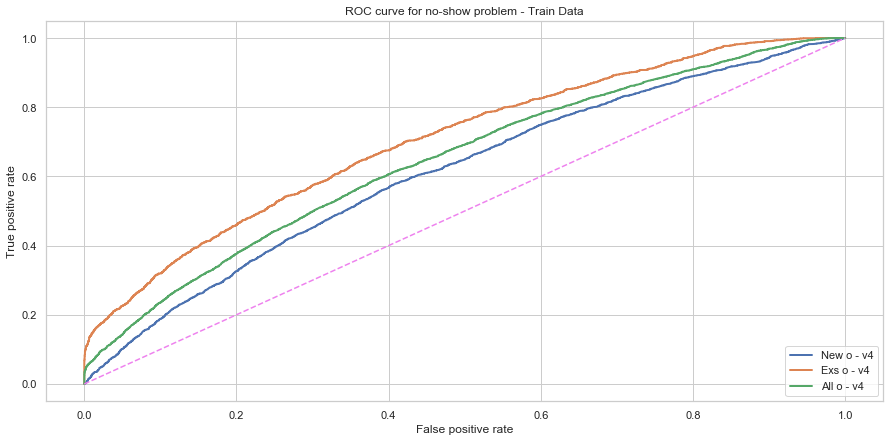

In [50]:
# Compare ROCs for:
fpr13, tpr13, thresholds13 = roc_curve(y_test_new, y_test_new_prob) # new
fpr14, tpr14, thresholds14 = roc_curve(y_test_exs, y_test_exs_prob) # exs
fpr15, tpr15, thresholds15 = roc_curve(y_test, y_test_all_prob) # exs


plt.figure(figsize=(15,7))

plt.plot(fpr13, tpr13,lw=2,label='New o - v4')
plt.plot(fpr14, tpr14,lw=2,label='Exs o - v4')
plt.plot(fpr15, tpr15,lw=2,label='All o - v4')
# plt.plot(fpr16, tpr16,lw=2,label='LGB o - v4')

plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.legend(loc='lower right')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for no-show problem - Train Data');

In [21]:
with open('pickles/appt_v2_all0.pickle','rb') as read_file:
    appt_v4 = pickle.load(read_file)

In [24]:
## run for appt_v2_all0 - all appts, uses prior_appt_count and prior_no_show_count
feature_cols = ['Gender','Age2','Neighbourhood2','Scholarship','Hipertension','Diabetes','Alcoholism',
                'Handcap_bin','SMS_received','SchedDayofWeek','ApptDayofWeek','DayDiff2',
                'Reschedule','Follow_up','prior_appt_count','prior_no_show_count','No_show_num']
a_Xv4 = appt_v4[feature_cols]
a_Xv4 = pd.get_dummies(a_Xv4, columns = ['Gender','Neighbourhood2','SchedDayofWeek','ApptDayofWeek'])
a_Xv4.drop(columns=['Gender_F','Neighbourhood2_OTHER','SchedDayofWeek_Monday','ApptDayofWeek_Monday'],inplace=True)
Xv4_cols = np.array(a_Xv4.columns)
# a_Xv4.info()

In [36]:
new = a_Xv4.loc[a_Xv4['prior_appt_count']==0]
exs = a_Xv4.loc[a_Xv4['prior_appt_count']>0]
print(new.shape, exs.shape)

(45710, 87) (25453, 87)


In [37]:
#new
X_new, y_new = new.drop(['No_show_num'],axis=1), new['No_show_num']
Xnew_train, Xnew_test, ynew_train, ynew_test = train_test_split(X_new, y_new, test_size = 0.25, random_state = 10, stratify = y_new)

In [40]:
#exist
X_exs, y_exs = exs.drop(['No_show_num'],axis=1), exs['No_show_num']
Xexs_train, Xexs_test, yexs_train, yexs_test = train_test_split(X_exs, y_exs, test_size = 0.25, random_state = 10, stratify = y_exs)

In [41]:
def oversample(X_train,y_train):
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_sample(X_train,y_train)
    X_resampled = pd.DataFrame(X_resampled,columns=X_train.columns)
    print(Counter(y_resampled))
    return X_resampled, y_resampled

In [44]:
Xnew_train_r, ynew_train_r = oversample(Xnew_train,ynew_train)

Counter({1: 24536, 0: 24536})


In [43]:
Xexs_train_r, yexs_train_r = oversample(Xexs_train,yexs_train)

Counter({0: 13739, 1: 13739})


In [45]:
#XGB - new
XGB = XGBClassifier(n_estimator=1000,max_depth=4,random_state=43)
XGB.fit(Xnew_train_r,ynew_train_r)
ynew_test_XGB_o = XGB.predict(Xnew_test)
ynew_test_XGB_o_prob = XGB.predict_proba(Xnew_test)[:,1]
print_scores(ynew_test,ynew_test_XGB_o)
print(f'XGB o - new: {roc_auc_score(ynew_test, ynew_test_XGB_o_prob):.3f}') # RFC

Accuracy score: 0.5920546027301365
F1 score: 0.44100719424460433
Precision (true + / all predicted +): 0.36122569239835
Recall (true + / all actual +): 0.5660203139427517
XGB o - new: 0.616


In [46]:
#XGB - exs
XGB = XGBClassifier(n_estimator=1000,max_depth=4,random_state=43)
XGB.fit(Xexs_train_r,yexs_train_r)
yexs_test_XGB_o = XGB.predict(Xexs_test)
yexs_test_XGB_o_prob = XGB.predict_proba(Xexs_test)[:,1]
print_scores(yexs_test,yexs_test_XGB_o)
print(f'XGB o - exs: {roc_auc_score(yexs_test, yexs_test_XGB_o_prob):.3f}') # RFC

Accuracy score: 0.6440917661847895
F1 score: 0.45355850422195415
Precision (true + / all predicted +): 0.39796782387806945
Recall (true + / all actual +): 0.5272013460459899
XGB o - exs: 0.659
